## Predicting Covid-19 Antibody Epitopes for Potential Vaccine Development

The Covid-19 pandemic that began in 2019 has become a global health crisis. Hopes of ending the pandemic is pinned on the effectiveness of currently available vaccines. However, all avenues of vaccine development need to be continuously evaluated to help develop vaccines rapidly to blunt the spread of such highly virulent strains of viruses in the future.   
   
The project described in this notebook uses a dataset from kaggle titled : 'COVID-19/SARS B-cell Epitope Prediction.A simple dataset for epitope prediction used in vaccine development' (https://www.kaggle.com/futurecorporation/epitope-prediction). It was used to predict covid-19 (Sars-coV2) spike protein epitopes with (potential) antibody inducing capabilities. Being able to design vaccines in-silico, prior to starting any pre-clinical bench work, can be expected to expedite the process, especially when time is of the essence.    
   
The dataset consist of three csv files with peptide data;   
1) input_bcell.csv - range of different peptides that can or cannot induce B-cell activation and neutralizing antibody release   
2) input_sars.csv - range of different peptides obtained from the Sars-Cov1 spike protein that can or cannot induce B-cell    
                 activation.    
3) input_covid.csv - range of different peptides obtained from the Sars-Cov2 (covid-19) spike protein. They serve as test                            peptide samples for a machine learning model trained on bcell and sars data in the above csv files.

## Import libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## Read csv files into dataframes

In [6]:
bcell = pd.read_csv('input_bcell.csv') #B cell dataset
sars = pd.read_csv('input_sars.csv') # sars dataset
bcell_sars = pd.concat([bcell,sars], axis=0, ignore_index = True) # B cell and sars datasets combined
covid = pd.read_csv('input_covid.csv') #covid-19 dataset

In [7]:
#create 'length' column in the dfs
# this column will hold the amino acid length of each of the peptides
for df in [bcell, sars, covid, bcell_sars]:
    df['length'] = df['end_position'] - df['start_position']+1

# Exploratory Data Analysis

In [8]:
bcell_sars.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,length
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1,5
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1,5
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1,5
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,1,5
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1,5


##  1) Distribution of peptide features
   
Plot the histograms for the following peptide features:   

1) chou_fasman : peptide feature, β turn   
2) emini : peptide feature, relative surface accessibility   
3) kolaskar_tongaonkar : peptide feature, antigenicity   
4) parker : peptide feature, hydrophobicity   

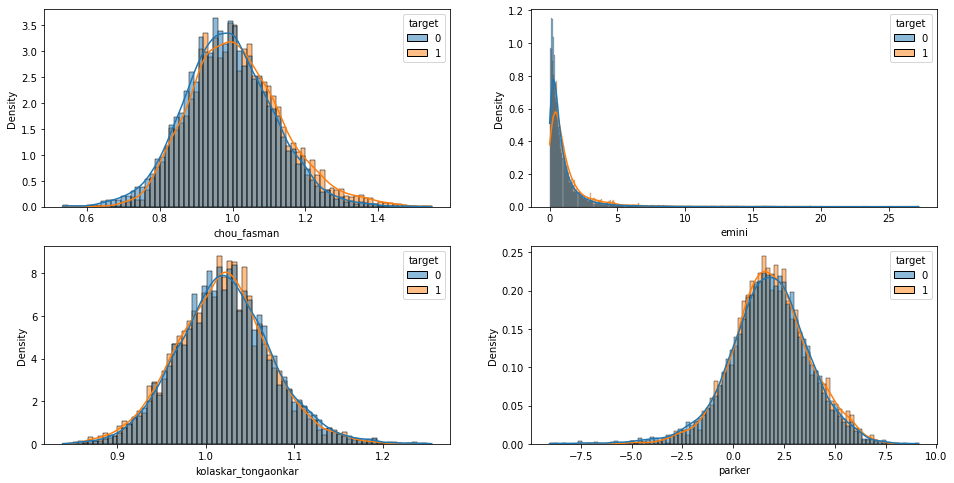

In [9]:
fig, axes = plt.subplots(2, 2,figsize=(16,8))
axes = [x for a in axes for x in a]
for ind, prop in enumerate (["chou_fasman","emini","kolaskar_tongaonkar","parker"]):
    sns.histplot(x=bcell[prop], hue=bcell['target'],stat="density", common_norm=False, kde=True, ax=axes[ind])

For the four peptide features, there are no discernible differences between peptides that can or cannot induce neutralizing antibodies (i.e. target 1 vs. 0).

## 2) Distribution of protein features
   
Plot the histograms for the following protein features:   
   
1) isoelectric_point : protein feature, the pH at which the protein has no net charge   
2) aromacity: protein feature, presence of aromatic amino acids (phenylalanine, tyrosine, tryptophan and histidine)   
3) hydrophobicity : protein feature, a measure of polarity and ability to interact with water molecules   
4) stability : protein feature, can it exist in its folded conformation or does it easily denature?   

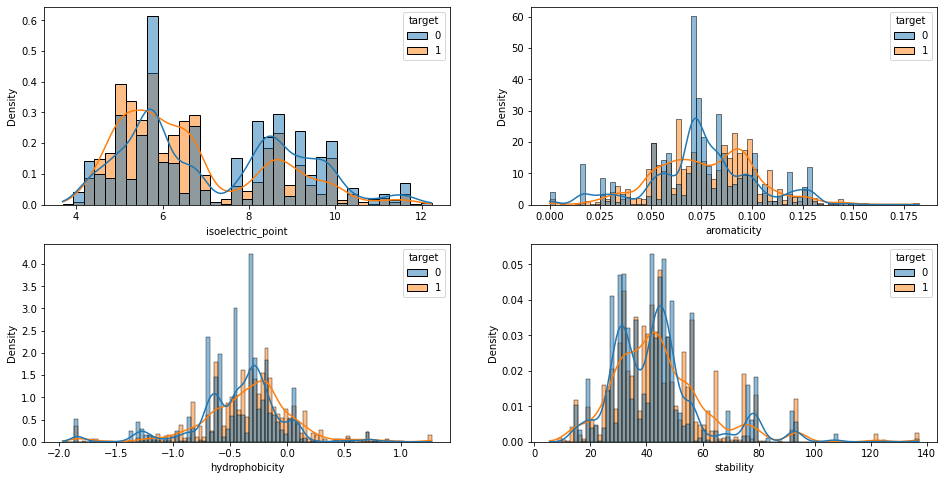

In [11]:
fig, axes = plt.subplots(2, 2,figsize=(16,8))
axes = [x for a in axes for x in a]
for ind, prop in enumerate (["isoelectric_point", "aromaticity", "hydrophobicity", "stability"]):
    sns.histplot(x=bcell[prop], hue=bcell['target'],stat="density", common_norm=False, kde=True, ax=axes[ind])

There is also no clear differentiation between the protein features of those peptides that can or cannot induce neutralizing antibodies (i.e. target 1 vs. 0).

# Train Logistic Regression model with B-cell data and predict antibody induction with sars-derived peptides

In [12]:
gkf = GroupKFold(n_splits=5)#create GroupKFold object with 5 splits of the data

In [13]:
#create training, testing and prediction datasets
X_bcell=bcell.drop(['parent_protein_id', 'protein_seq', 'start_position', 'end_position', 'peptide_seq', 'target'], axis=1)
y_bcell=bcell.target
X_sars=sars.drop(['parent_protein_id', 'protein_seq', 'start_position', 'end_position', 'peptide_seq', 'target'], axis=1)

## Model training and predicting procedure

1) Split the dataframe containing B-cell data using GroupKFold since there are groups of peptides derived
from several parent proteins. GroupKFold prevents mixing of groups between training and testing data sets.   
2) Train and test the LogisticRegression model.   
3) For each training run, predict antibody induction using the whole sars dataset.   
4) Calculate the average classification over the number of repetitions (i.e. number of folds trained on).   

Here an assumption was made where an average calssification value of 1 indicates a 'strong candidate' for induction of neutralizing antibodies (i.e. prediction of 1 for each training/predicting run - see below)    
Code adapted and modified from Future Corporation notebook on kaggle  

In [14]:
scores_logreg = []
model_logreg=LogisticRegression(max_iter=500,C=1)
predict=np.zeros(len(sars))

i=0
for train_index, test_index in gkf.split(X_bcell, y_bcell, bcell['parent_protein_id']): #loop through the 5 GroupKFolds where the groups are the 'parent_protein_id'
    X_train = X_bcell.loc[train_index].values
    y_train = y_bcell.loc[train_index].values
    X_test = X_bcell.loc[test_index].values
    y_test = y_bcell.loc[test_index].values
    model_logreg.fit(X_train, y_train)
    scores_logreg.append(model_logreg.score(X_test, y_test))
    predict+=model_logreg.predict(X_sars.values)
    i+=1
    if i==gkf.n_splits:
        predict=predict/gkf.n_splits
    
    
print('LogisticRegression mean score: ', np.mean(scores_logreg))
print(predict[:220])#display a portion of the output array to show the various clssification values

LogisticRegression mean score:  0.7280191825947953
[0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.2 0.  0.  0.4 0.2 0.  0.  0.2 0.
 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.2 0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.2
 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.4 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.8 0.8 0.8 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.8 0.6 1.  1.  1.  1.  1.  1.
 1.  0.8 1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.8 0.8 0.2 0.  0.  0.
 0.  0.2 0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.6 0.8 0.  0. ]


In [15]:
#How well did the B-cell data help predict the antibody responses of sars peptides?
#Convert all classification values of the array that are >= 0.5 to an integer (i.e. 1)
#Code modified from Future Corporation notebook
print("Accuracy:", accuracy_score(sars["target"].values, np.int32(predict >= 0.5)))
print(classification_report(sars["target"].values, np.int32(predict >= 0.5)))

Accuracy: 0.7653846153846153
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       380
           1       0.72      0.21      0.32       140

    accuracy                           0.77       520
   macro avg       0.75      0.59      0.59       520
weighted avg       0.76      0.77      0.71       520



Precision is acceptable but not recall and F1-score for those peptides predicted to induce antibody reactions (i.e. Class 1). Thus, misclassification of true positives but not true negatives may have a negative impact on covid-19 antibody prediction capabilities below.

# Train Logistic Regression model with B-cell + sars data and predict antibody induction with covid-19-derived peptides

In [16]:
covid.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,length
0,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,1,5,MGILP,0.948,0.280,1.033,-2.72,6.03595,0.10929,-0.138642,31.377603,5
1,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,2,6,GILPS,1.114,0.379,1.070,-0.58,6.03595,0.10929,-0.138642,31.377603,5
2,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,3,7,ILPSP,1.106,0.592,1.108,-1.30,6.03595,0.10929,-0.138642,31.377603,5
3,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,4,8,LPSPG,1.324,0.836,1.053,1.44,6.03595,0.10929,-0.138642,31.377603,5
4,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,5,9,PSPGM,1.326,1.004,0.968,2.44,6.03595,0.10929,-0.138642,31.377603,5


In [17]:
covid['parent_protein_id'].value_counts() #only protein and peptide data  from one parent protein is in this dataframe

6VYB_A    20312
Name: parent_protein_id, dtype: int64

In [18]:
# Define the training and prediction data
X_bcell_sars = bcell_sars.drop(['parent_protein_id', 'protein_seq', 'start_position', 'end_position', 'peptide_seq', 'target'], axis=1)
y_bcell_sars = bcell_sars['target']
X_covid = covid.drop(['parent_protein_id', 'protein_seq', 'start_position', 'end_position', 'peptide_seq'], axis=1)

## Model training and predicting procedure

1) Split the dataframe containing B-cell+sars data using GroupKFold.   
2) Train and test the LogisticRegression model.   
3) For each training run, predict antibody induction using the whole covid-19 dataset.   
4) Calculate the average classification over the number of repetitions (i.e. number of folds trained on). 

In [19]:
model_logreg=LogisticRegression(max_iter=500,C=1)
covid_predict=np.zeros(len(covid))

i=0
for train_index, test_index in gkf.split(X_bcell_sars, y_bcell_sars, bcell_sars['parent_protein_id']): #loop through the 5 GroupKFolds where the groups are the 'parent_protein_id'
    X_train = X_bcell_sars.loc[train_index].values
    y_train = y_bcell_sars.loc[train_index].values
    X_test = X_bcell_sars.loc[test_index].values
    y_test = y_bcell_sars.loc[test_index].values
    model_logreg.fit(X_train, y_train)
    covid_predict+=model_logreg.predict(X_covid.values)
    i+=1
    if i==gkf.n_splits:
        covid_predict=covid_predict/gkf.n_splits
    
    
print('LogisticRegression mean score: ', np.mean(scores_logreg))   
print(covid_predict)

LogisticRegression mean score:  0.7280191825947953
[0. 0. 0. ... 0. 0. 0.]


In [20]:
covid_target = np.int32(covid_predict >= 0.5)#convert all decimals greater than or equal to 0.5 to integers (i.e. 1's)

In [21]:
covid_final=covid.copy()#create deep copy of covid df
covid_final['target']=covid_target
covid_final['target'].value_counts()
#44 peptides were identified as potential candidates for antibody induction

0    20268
1       44
Name: target, dtype: int64

There are a range of classification values, of which values >=0.5 can be reclassified as '1'. It is interesting to note that there are 20 peptides, with a classification of 1. This indicates that with each train/predict run above, each of these peptides were predicted to be a candidate. Hence we will assume these 20 peptides to be 'strong candidates' for inducing anti-covid-19 antibodies.

In [23]:
covid_final[covid_final['target']==1]['peptide_seq'] #the peptide sequences of 44 potential covid vaccine candidates

5927                PDPSKPSKR
5928                DPSKPSKRS
7200               PDPSKPSKRS
10350           YYHKNNKSWMESE
12282          PDPSKPSKRSFIED
12624          KEELDKYFKNHTSP
12887         YYHKNNKSWMESEFR
13892         KEELDKYFKNHTSPD
15158        FKEELDKYFKNHTSPD
16418       QPELDSFKEELDKYFKN
16422       DSFKEELDKYFKNHTSP
16423       SFKEELDKYFKNHTSPD
16425       KEELDKYFKNHTSPDVD
16685      YYHKNNKSWMESEFRVYS
17679      YDPLQPELDSFKEELDKY
17683      QPELDSFKEELDKYFKNH
17684      PELDSFKEELDKYFKNHT
17687      DSFKEELDKYFKNHTSPD
17949     YYHKNNKSWMESEFRVYSS
17952     KNNKSWMESEFRVYSSANN
18253     NYNYLYRLFRKSNLKPFER
18254     YNYLYRLFRKSNLKPFERD
18944     DPLQPELDSFKEELDKYFK
18945     PLQPELDSFKEELDKYFKN
18947     QPELDSFKEELDKYFKNHT
18948     PELDSFKEELDKYFKNHTS
18949     ELDSFKEELDKYFKNHTSP
18950     LDSFKEELDKYFKNHTSPD
18951     DSFKEELDKYFKNHTSPDV
18952     SFKEELDKYFKNHTSPDVD
19212    YYHKNNKSWMESEFRVYSSA
19213    YHKNNKSWMESEFRVYSSAN
19214    HKNNKSWMESEFRVYSSANN
19515    G

## Amino acid sequences of Sars-coV2 spike protein mimics coded for by Pfizer and Moderna mRNA vaccines

In [22]:
#the following are the translated amino acid sequences from pfizer and Moderna mRNA vaccines. 
# mRNA sequences copied from https://github.com/NAalytics/Assemblies-of-putative-SARS-CoV2-spike-encoding-mRNA-sequences-for-vaccines-BNT-162b2-and-mRNA-1273
# mRNA sequences translated at https://web.expasy.org/translate/

pfizer = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
moderna = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"

In [24]:
pfizer==moderna #the peptide sequences are identical. This is the case even though the mRNA sequences are 
# NOT identical (not shown)

True

In [25]:
# All of the 'strong' peptide candidates are part of the covid spike protein sequence. 
#This is expected since the single parent protein is the spike protein
i=0
for seq in covid_final[covid_final['target']==1]['peptide_seq']:
    if seq in pfizer: continue
    else: i+=1
print(i, 'peptides are not part of SARS-Cov2 sequence')

0 peptides are not part of SARS-Cov2 sequence


In [27]:
#create an additional colum in covid_final containing the initial predictions from the model

covid_final['initial_prediction']=covid_predict
covid_final['initial_prediction'].value_counts()
# It is interesting to note that 20 of these candidates were predicted for antibody induction with each of the 5 prediction rounds
# These 20 peptides will be assumed to be 'strong candidates' for inducing covid-19 neutralizing antibodies

0.0    20148
0.2      103
1.0       20
0.4       17
0.8       13
0.6       11
Name: initial_prediction, dtype: int64

## Align the predicted candidate peptides with the translated spike protein amino acid sequence

## 'Strong candidate' epitopes

In [35]:
# Align the latter region of the spike protein sequence with the 'strong candidate' peptides

disp_seq=pfizer[1129:1180]
print('1130', '<'*10, 'amino acid pos.', '>'*15, '1181')
print('|', '.'*47, '|')
print(disp_seq,' <- SARS-COV2 spike protein')
for seq in covid_final[covid_final['initial_prediction']==1]['peptide_seq']:
    if pfizer.find(seq)>1129:
        print('.'*(pfizer.find(seq)-1129)+seq+'.'*(1180-pfizer.find(seq)-len(seq)))
        

1130 <<<<<<<<<< amino acid pos. >>>>>>>>>>>>>>> 1181
| ............................................... |
IGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQ  <- SARS-COV2 spike protein
...................KEELDKYFKNHTSPD.................
..................FKEELDKYFKNHTSPD.................
................DSFKEELDKYFKNHTSP..................
.................SFKEELDKYFKNHTSPD.................
...................KEELDKYFKNHTSPDVD...............
............QPELDSFKEELDKYFKNH.....................
................DSFKEELDKYFKNHTSPD.................
............QPELDSFKEELDKYFKNHT....................
.............PELDSFKEELDKYFKNHTS...................
..............ELDSFKEELDKYFKNHTSP..................
...............LDSFKEELDKYFKNHTSPD.................
........YDPLQPELDSFKEELDKYFK.......................
.........DPLQPELDSFKEELDKYFKN......................
............QPELDSFKEELDKYFKNHTS...................
.............PELDSFKEELDKYFKNHTSP..................
..............ELDSFKEELDKYFKNHTSPD.

In [47]:
covid_final[covid_final['initial_prediction']==1]['length'].mean()

17.65

Of the 20 strong candidate peptides, 17 (85%) aligned within a small region of the spike protein sequence above. 

## 'Weaker candidate' epitopes

In [42]:
# Align the latter region of the spike protein sequence with the weaker candidate peptides (average classification values of 0.6 or 0.8)

disp_seq=pfizer[1129:1180]
print('1130', '<'*10, 'amino acid pos.', '>'*15, '1181')
print('|', '.'*47, '|')
print(disp_seq,' <- SARS-COV2 spike protein')
for seq in covid_final[(covid_final['initial_prediction']>=0.6) & (covid_final['initial_prediction']<=0.8)]['peptide_seq']:
    if pfizer.find(seq)>1129:
        print('.'*(pfizer.find(seq)-1129)+seq+'.'*(1180-pfizer.find(seq)-len(seq)))

1130 <<<<<<<<<< amino acid pos. >>>>>>>>>>>>>>> 1181
| ............................................... |
IGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQ  <- SARS-COV2 spike protein
...................KEELDKYFKNHTSP..................
............QPELDSFKEELDKYFKN......................
........YDPLQPELDSFKEELDKY.........................
.............PELDSFKEELDKYFKNHT....................
.........DPLQPELDSFKEELDKYFK.......................
..........PLQPELDSFKEELDKYFKN......................
................DSFKEELDKYFKNHTSPDV................
.................SFKEELDKYFKNHTSPDVD...............
..........PLQPELDSFKEELDKYFKNH.....................
...........LQPELDSFKEELDKYFKNHT....................
...................KEELDKYFKNHTSPDVDLGD............


In [48]:
covid_final[(covid_final['initial_prediction']>=0.6) & (covid_final['initial_prediction']<=0.8)]['length'].mean()

17.833333333333332

Of the 24 weaker candidate peptides, 11 (46%) aligned within a small region of the spike protein sequence above. The average length of the peptides was similar to the average 'strong candidate' peptides.

## 'Weakest candidate' epitopes

In [45]:
# Align the latter region of the spike protein sequence with the 'weakest candidate' peptides (average classification values of 0.2 or 0.4)

disp_seq=pfizer[1129:1180]
print('1130', '<'*10, 'amino acid pos.', '>'*15, '1181')
print('|', '.'*47, '|')
print(disp_seq,' <- SARS-COV2 spike protein')
for seq in covid_final[(covid_final['initial_prediction']>=0.2) & (covid_final['initial_prediction']<=0.4)]['peptide_seq']:
    if pfizer.find(seq)>1129:
        print('.'*(pfizer.find(seq)-1129)+seq+'.'*(1180-pfizer.find(seq)-len(seq)))

1130 <<<<<<<<<< amino acid pos. >>>>>>>>>>>>>>> 1181
| ............................................... |
IGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQ  <- SARS-COV2 spike protein
.......................DKYFKNHTSPD.................
...................KEELDKYFKNHT....................
...................KEELDKYFKNHTS...................
....................EELDKYFKNHTSP..................
.....................ELDKYFKNHTSPD.................
................DSFKEELDKYFKNH.....................
....................EELDKYFKNHTSPD.................
................DSFKEELDKYFKNHT....................
..................FKEELDKYFKNHTSP..................
............QPELDSFKEELDKYFK.......................
.............PELDSFKEELDKYFKN......................
................DSFKEELDKYFKNHTS...................
.................SFKEELDKYFKNHTSP..................
...................KEELDKYFKNHTSPDV................
....................EELDKYFKNHTSPDVD...............
........YDPLQPELDSFKEELDK..........

In [50]:
covid_final[(covid_final['initial_prediction']>=0.2) & (covid_final['initial_prediction']<=0.4)]['length'].mean()

15.808333333333334

Only 37 of the 120 (31%) 'weakest candidate' peptides align within the small region of the covid-19 spike protein. These peptides are also slightly shorter by about 2 amino acids on average compared to the stronger candidates.

# Concluding Remarks

1) Using a series of B-cell and Sars-Cov1-derived peptides, a Logistic Regression model was used to predict the ability of Sars-Cov2 (Covid-19)-derived peptides to induce an antibody reaction. The ability to predict the induction of neutralizing antibodies in-silico may prove useful as well as expedite the vaccine development process.         
2) Misclassification of true positives is a clear problem for the model as evidenced by poor recall and F1-Score metrics. Lack of clear differences between features of those peptide that induce neutralizing antibodies versus those that do not may have affected the model's training and subsequently its predictive capability.     
3) It is also noteworthy to mention that according to the description of the original data, "Positive-High," "Positive-Intermediate," "Positive-Low," antibody activity labels were all grouped into a single label as "Positive" (target=1) that may contribute to the model's poor performance. Such a mixture of peptide data may lead to 'confusion' during prediction.    
4) Regardless of this weakness, the model was able to predict 20 SARS-Cov2 epitope candidates that, in my opinion, may exert strong antibody responses in-vivo. Seventeen or 85% of these candidates align within a small region of the spike protein, close to its carboxyl terminus. In contrast, weaker epitope candidates showed that fewer of them (46% and 31%) aligned within the same region of the spike protein, perhaps indicating the strong antigenic properties of this region in a primary, secondary or tertiary protein structure and evoking an antibody response.    